## CSV to Zarr

#### Import libraries

In [126]:
import os
import fsspec
import numpy as np
import pandas as pd
import time
import zarr
import dask as da
import numcodecs
import xarray as xr
import matplotlib.pyplot as plt

#### Generate numpy array

In [98]:
fs = fsspec.filesystem('s3', anon=True)
all_files = fs.glob(f's3://imos-data-pixeldrill/viet-test/csv/*.csv')

start_time = time.time()
dfs_values = []
columns = []
for i, file in enumerate(all_files):
    s3_fn = 's3://' + file
    with fs.open(s3_fn, "rb") as f:
        df_metadata = pd.read_csv(f, nrows=1)
    with fs.open(s3_fn, "rb") as f:
        df_data = pd.read_csv(f, skiprows=[0,1])

    df = pd.concat([df_metadata, df_data], axis=0, ignore_index=True)
    df.ffill(axis=0, inplace=True)
    
    if (i == 0):
        columns = df.columns #same columns across the iterations, do this once
    
    df_value = df.values.tolist()
    dfs_values = dfs_values + df_value #growing a dataframe directly is bad, better to accumulate dataframe's values in a list first

# generate the dataframe of all csv files from accumulated list values
dfs = pd.DataFrame(data=dfs_values, columns=columns)
# set 'time' as a dimension
dfs = dfs.set_index(['time'])

# generate xarray dataset from the dataframe above
ds = dfs.to_xarray()

print("---------- Total: %.2f seconds ----------" % (time.time() - start_time))

---------- Total: 6.65 seconds ----------


#### Xarray to zarr

In [116]:
start_time = time.time()
ds.to_zarr(store='/home/ec2-user/SageMaker/nc2zarr/notebooks/csv/output/csv.zarr/', mode='w', consolidated=True)
# chunked = ds.chunk(chunks=64)
print("---------- Total: %.2f seconds ----------" % (time.time() - start_time))

---------- Total: 0.51 seconds ----------


#### Open zarr

In [123]:
test = xr.open_zarr('/home/ec2-user/SageMaker/nc2zarr/notebooks/csv/output/csv.zarr/')

In [124]:
test.sea_water_temperature

<xarray.DataArray 'sea_water_temperature' (time: 229592)>
dask.array<open_dataset-ded76aaf6e26ac7702c995bf14f3ab9asea_water_temperature, shape=(229592,), dtype=float64, chunksize=(57398,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object '' '20120303T063355Z' ... '20120312T085051Z'

CPU times: user 14.5 ms, sys: 7.79 ms, total: 22.3 ms
Wall time: 20.9 ms


(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([26.786, 26.886, 26.986, 27.086, 27.186, 27.286, 27.386, 27.486,
        27.586, 27.686, 27.786]),
 <BarContainer object of 10 artists>)

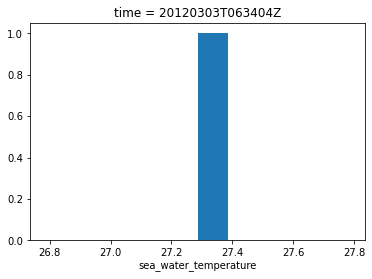

In [136]:
%%time
# timeseries = test.sel(method='nearest').compute()
test.sea_water_temperature.isel(time=10).plot()